## 0 Set UP Coding Environment

In [ ]:
import os
import yaml
import pickle
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    classification_report,
    confusion_matrix,
    make_scorer,
    recall_score,
    accuracy_score
)

# XGBoost
import xgboost as xgb

# Imbalanced data handling
from imblearn.over_sampling import SMOTE

# Random distributions for hyperparameter tuning
from scipy.stats import randint, uniform

# Suppress warnings
import warnings

from scipy.stats import bootstrap


warnings.filterwarnings("ignore")

# Define directories
data_dir = '../data/'  # Path to the data folder
figs_dir = '../figs/'  # Path to save figures

# Confirmation of setup
print(f"Data directory: {os.path.abspath(data_dir)}")
print(f"Figures will be saved in: {os.path.abspath(figs_dir)}")

# Files paths
diabetic_data = "../data/diabetic_data.csv"  
IDS_mapping = '../data/IDS_mapping.csv'

Data directory: /Users/yuanyuangao/Library/Mobile Documents/com~apple~CloudDocs/Irene Chen's Lab/data
Figures will be saved in: /Users/yuanyuangao/Library/Mobile Documents/com~apple~CloudDocs/Irene Chen's Lab/figs


## 1.1 Data Exploration

Download the diabetes dataset and review the corresponding publication [SDG+14]. Graph the 30-day readmission rates by age, gender, and race. Which groups correlate with higher readmission rates?


In [ ]:
# Load the datasets
df = pd.read_csv(diabetic_data)

# Print detailed null value information
null_details = df.isnull().sum()
print("Detailed missing value information in the orignal dataset:")
print(null_details[null_details > 0])
print("Total missing values remaining in the orignal dataset:", df.isnull().sum().sum())

# Drop unnecessary columns
df = df.drop(columns=['encounter_id', 'patient_nbr', 'weight', 'payer_code'], errors='ignore')

# Impute missing values in 'medical_specialty' with 'missing'
df['medical_specialty'] = df['medical_specialty'].fillna('missing')

# # Remove duplicate patient encounters and keep only the first encounter per patient
# df_diabetes = df_diabetes.sort_values(by=['encounter_id']).drop_duplicates(subset=['patient_nbr'], keep='first')

# Remove encounters with discharge to hospice or patient death
df = df[~df['discharge_disposition_id'].isin([11, 19, 20, 21])]

# Keep only admissions with length of stay between 1 and 14 days
df = df[(df['time_in_hospital'] >= 1) & (df['time_in_hospital'] <= 14)]

# Replace "?" in the 'race' column with "missing"
df['race'] = df['race'].replace('?', 'missing')

# Convert readmitted column to binary (1 for <30 days, 0 otherwise)
df['readmitted'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

# Display basic info
df.info()
df.head()


Detailed missing value information in the orignal dataset:
max_glu_serum    96420
A1Cresult        84748
dtype: int64
Total missing values remaining in the orignal dataset: 181168
<class 'pandas.core.frame.DataFrame'>
Index: 100114 entries, 0 to 101765
Data columns (total 46 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      100114 non-null  object
 1   gender                    100114 non-null  object
 2   age                       100114 non-null  object
 3   admission_type_id         100114 non-null  int64 
 4   discharge_disposition_id  100114 non-null  int64 
 5   admission_source_id       100114 non-null  int64 
 6   time_in_hospital          100114 non-null  int64 
 7   medical_specialty         100114 non-null  object
 8   num_lab_procedures        100114 non-null  int64 
 9   num_procedures            100114 non-null  int64 
 10  num_medications           100114 non-null  int64 

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,Pediatrics-Endocrinology,41,0,...,No,No,No,No,No,No,No,No,No,0
1,Caucasian,Female,[10-20),1,1,7,3,?,59,0,...,No,Up,No,No,No,No,No,Ch,Yes,0
2,AfricanAmerican,Female,[20-30),1,1,7,2,?,11,5,...,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,[30-40),1,1,7,2,?,44,1,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,[40-50),1,1,7,1,?,51,0,...,No,Steady,No,No,No,No,No,Ch,Yes,0


### 1.1.1 Graph the 30-day readmission rates by age, gender, and race

<Figure size 1000x600 with 0 Axes>

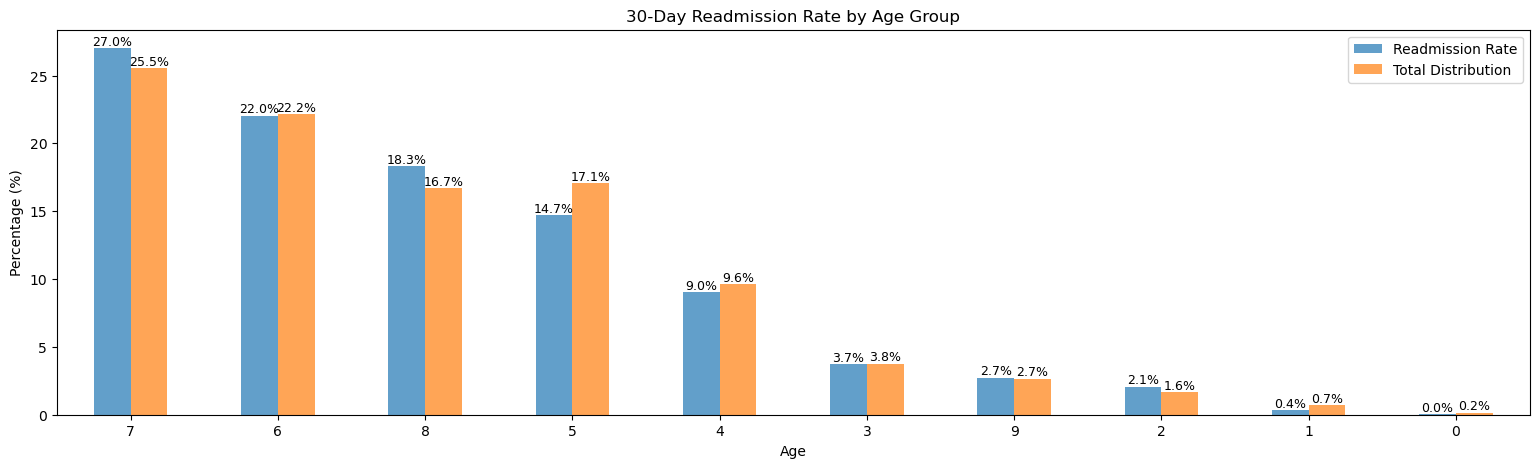

<Figure size 1000x600 with 0 Axes>

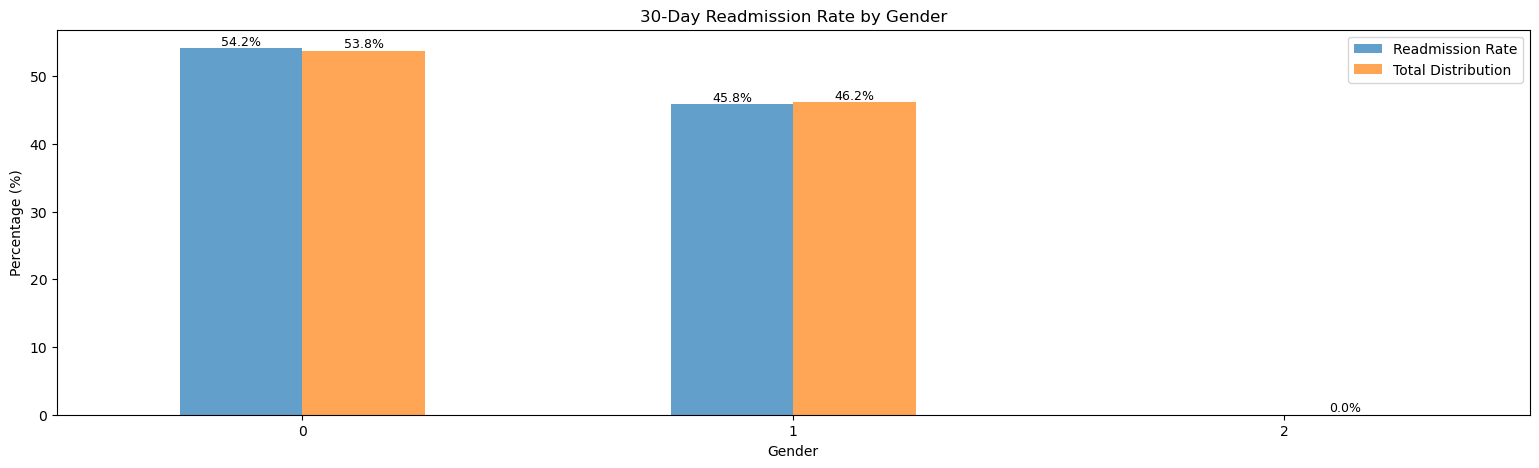

<Figure size 1000x600 with 0 Axes>

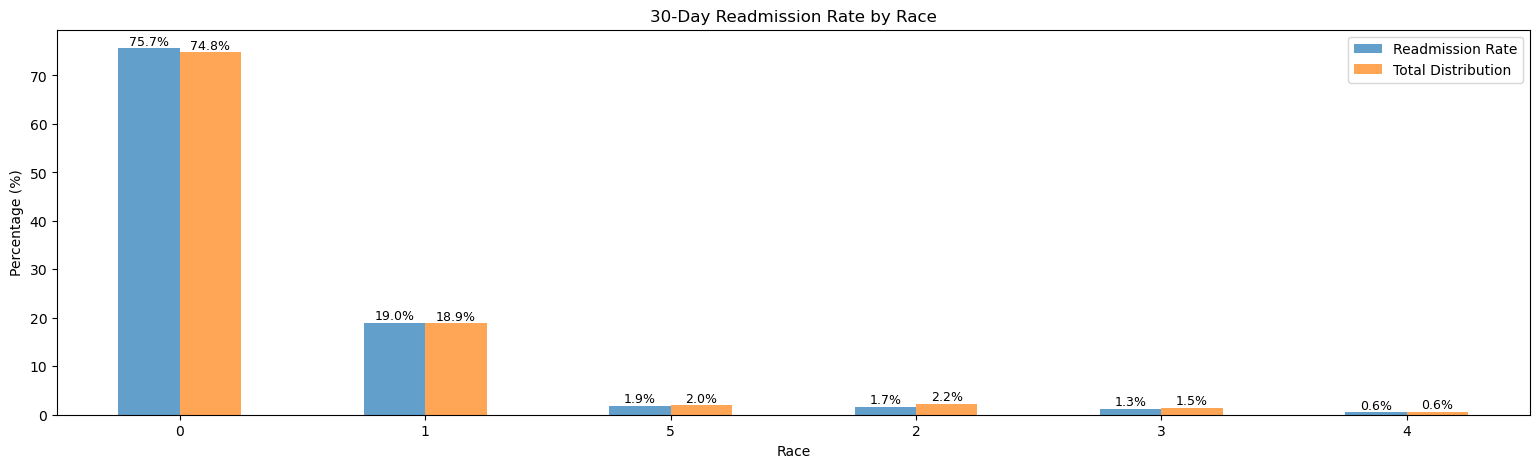

Groups with Highest Readmission Rates:
age  gender  race
9    1       5       0.500000
1    0       3       0.250000
8    1       5       0.236364
2    0       0       0.195008
7    1       4       0.188889
9    1       2       0.172414
6    1       4       0.160494
3    0       3       0.156863
4    1       5       0.153005
7    1       5       0.145455
Name: readmitted, dtype: float64
Highly Correlated Variables:
change       diabetesMed    0.505762
diabetesMed  change         0.505762
             insulin        0.524988
insulin      diabetesMed    0.524988
dtype: float64


In [ ]:
# Function to plot 30-day readmission rates with labels and sorted bars
def plot_readmission_rates(column, title):
    readmission_counts = df[df['readmitted'] == 1][column].value_counts(normalize=True) * 100
    total_counts = df[column].value_counts(normalize=True) * 100
    combined_counts = pd.DataFrame({'Readmission Rate': readmission_counts, 'Total Distribution': total_counts})
    combined_counts = combined_counts.sort_values(by='Readmission Rate', ascending=False)
    plt.figure(figsize=(10, 6))
    ax = combined_counts.plot(kind='bar', figsize=(19, 5), alpha=0.7)
    plt.xlabel(column.capitalize())
    plt.ylabel('Percentage (%)')
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    
    # Add value labels on bars and rotate
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', rotation=0, fontsize=9)
    
    plt.show()

# Plot readmission rates by age, gender, and race
plot_readmission_rates('age', '30-Day Readmission Rate by Age Group')
plot_readmission_rates('gender', '30-Day Readmission Rate by Gender')
plot_readmission_rates('race', '30-Day Readmission Rate by Race')

# Identify groups with higher readmission rates
if all(col in df.columns for col in ['age', 'gender', 'race']):
    high_readmission_groups = df.groupby(['age', 'gender', 'race'])['readmitted'].mean().sort_values(ascending=False).head(10)
    print("Groups with Highest Readmission Rates:")
    print(high_readmission_groups)

# Convert categorical variables to numeric where necessary
df = df.apply(lambda col: pd.factorize(col)[0] if col.dtype == 'object' else col)
# Filter for 30-day readmissions
df_30day_readmitted = df[df["readmitted"] == df["readmitted"].min()]

# Function to generate a heatmap of correlations
def plot_correlation_heatmap():
    correlation_matrix = df.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
    plt.title("Feature Correlation Heatmap")
    plt.savefig(os.path.join(figs_dir, "correlation_heatmap.pdf"))
    plt.close()
    
    # Print highly correlated variables
    correlated_vars = correlation_matrix.unstack().sort_values(ascending=True)
    high_correlation = correlated_vars[(abs(correlated_vars) > 0.5) & (abs(correlated_vars) < 1)]
    print("Highly Correlated Variables:")
    print(high_correlation)
    
plot_correlation_heatmap()

In [ ]:
# Save the cleaned dataset before encoding
cleaned_data_path = "../data/cleaned_diabetic_data.csv"
df.to_csv(cleaned_data_path, index=False)

### 1.1.2 Data Preprocessing


In [ ]:
def load_and_preprocess(filepath):
    df = pd.read_csv(filepath)

    categorical_cols = df.select_dtypes(include=['object']).columns
    numerical_cols = df.select_dtypes(include=['number']).columns.drop('readmitted')

    # One-hot encoding
    encoder = OneHotEncoder(drop="first", handle_unknown="ignore")
    encoded_cats = encoder.fit_transform(df[categorical_cols])

    # Impute missing values
    imputer = SimpleImputer(strategy="median")
    imputed_nums = imputer.fit_transform(df[numerical_cols])

    # Combine features
    X = np.hstack((imputed_nums, encoded_cats.toarray()))
    y = df["readmitted"]

    # Train-test split
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

if __name__ == "__main__":
    X_train, X_test, y_train, y_test = load_and_preprocess("../data/cleaned_diabetic_data.csv")
    print("Data Preprocessing Complete.")



Data Preprocessing Complete.


### 1.2 Model Development


### XGBoost Model

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/yuanyuangao/miniconda3/envs/215a/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:11:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuanyuangao/miniconda3/envs/215a/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:11:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuanyuangao/miniconda3/envs/215a/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:11:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuanyuangao/miniconda3/envs/215a/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:11:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_e

Best Parameters: {'colsample_bytree': 0.8037724259507192, 'gamma': 0.8526206184364576, 'learning_rate': 0.029515477895583855, 'max_depth': 6, 'n_estimators': 138, 'reg_alpha': 0.9656320330745594, 'reg_lambda': 4.041986740582305, 'subsample': 0.6523068845866853}
ROC AUC Score: 0.6679
              precision    recall  f1-score   support

           0       0.92      0.66      0.77     17752
           1       0.18      0.57      0.27      2271

    accuracy                           0.65     20023
   macro avg       0.55      0.62      0.52     20023
weighted avg       0.84      0.65      0.72     20023

Sensitivity (Recall): 0.5694
Specificity: 0.6639


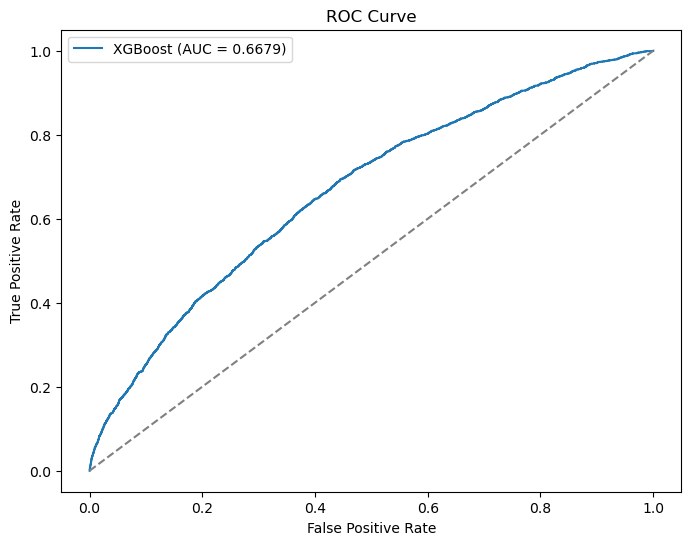

95% CI for AUC: (0.6555, 0.6799)
Best XGBoost model saved at: ../results/best_xgb_model.pkl
XGBoost training configuration saved at: ../results/xgb_training_config.yaml


In [ ]:
# Handle class imbalance with scale_pos_weight
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# Define XGBoost model
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

# Define hyperparameter grid
param_dist = {
    "n_estimators": randint(50, 300),
    "max_depth": randint(3, 15),
    "learning_rate": uniform(0.01, 0.3),
    "subsample": uniform(0.5, 0.5),
    "colsample_bytree": uniform(0.5, 0.5),
    "gamma": uniform(0, 5),
    "reg_alpha": uniform(0, 1),
    "reg_lambda": uniform(0, 5)
}

# Randomized Search CV
random_search = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist, 
    n_iter=50, scoring="roc_auc", cv=5, verbose=1, n_jobs=-1, random_state=42
)

# Fit model
random_search.fit(X_train, y_train)

# Best model
best_xgb = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")

# Predictions
y_pred_prob = best_xgb.predict_proba(X_test)[:, 1]
y_pred_class = (y_pred_prob > 0.5).astype(int)

# ROC AUC Score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC Score: {auc_score:.4f}")

# Classification Report
print(classification_report(y_test, y_pred_class))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_class)
tn, fp, fn, tp = cm.ravel()

# Sensitivity and Specificity Calculation
sensitivity = tp / (tp + fn)  # True Positive Rate (Recall)
specificity = tn / (tn + fp)  # True Negative Rate

print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

# ROC Curve Plot
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Bootstrapping for Confidence Interval
np.random.seed(42)
n_bootstraps = 1000
aucs = []

for _ in range(n_bootstraps):
    sample_indices = np.random.choice(len(y_test), size=len(y_test), replace=True)
    y_test_boot = np.array(y_test)[sample_indices]
    y_pred_boot = y_pred_prob[sample_indices]
    aucs.append(roc_auc_score(y_test_boot, y_pred_boot))

# Confidence Interval Calculation
lower_bound = np.percentile(aucs, 2.5)
upper_bound = np.percentile(aucs, 97.5)
print(f"95% CI for AUC: ({lower_bound:.4f}, {upper_bound:.4f})")

# Define results directory
results_dir = "../results/"
os.makedirs(results_dir, exist_ok=True)  

# Save the best XGBoost model
xgb_model_path = os.path.join(results_dir, "best_xgb_model.pkl")
with open(xgb_model_path, "wb") as f:
    pickle.dump(best_xgb, f)

print(f"Best XGBoost model saved at: {xgb_model_path}")

# Save training configuration and results in YAML
xgb_training_config = {
    "best_parameters": random_search.best_params_,
    "roc_auc_score": auc_score,
    "sensitivity": sensitivity,
    "specificity": specificity,
    "auc_confidence_interval": {
        "lower_bound": lower_bound,
        "upper_bound": upper_bound
    }
}

# Define path for YAML config file
xgb_config_path = os.path.join(results_dir, "xgb_training_config.yaml")

# Save YAML file
with open(xgb_config_path, "w") as file:
    yaml.dump(xgb_training_config, file, default_flow_style=False)

print(f"XGBoost training configuration saved at: {xgb_config_path}")



### Neural Network Model

### Linear Regression Model with L2

Best Regularization Parameter (C): 0.000774
Test ROC AUC Score: 0.6431
Sensitivity (Recall for Positive Class): 0.0123
Specificity (Recall for Negative Class): 0.9983

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     17752
           1       0.47      0.01      0.02      2271

    accuracy                           0.89     20023
   macro avg       0.68      0.51      0.48     20023
weighted avg       0.84      0.89      0.84     20023



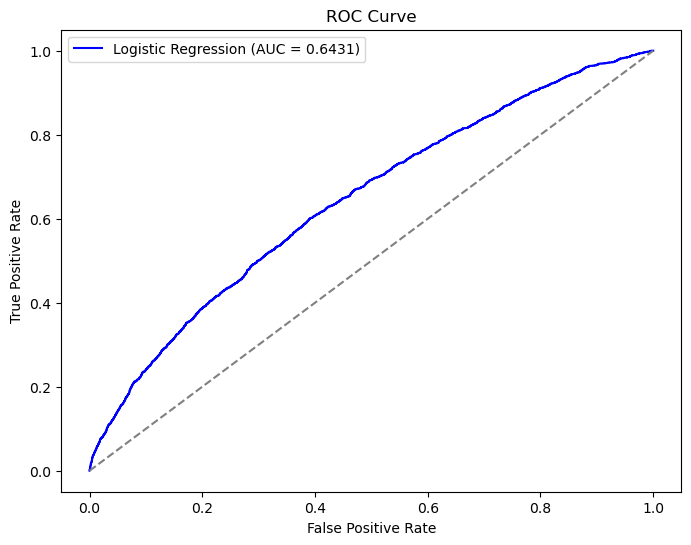

Logistic Regression model saved at: ../results/logistic_regression_model.pkl
Training configuration saved at: ../results/logistic_regression_training_config.yaml


In [ ]:
# Ensure Reproducibility
np.random.seed(42)

# Define results directory
results_dir = "../results/"
os.makedirs(results_dir, exist_ok=True)

# Define Logistic Regression Model with L2 Regularization (CV)
logistic_model = LogisticRegressionCV(
    Cs=np.logspace(-4, 4, 10),  # Exploring regularization strength from 1e-4 to 1e4
    cv=5,  # 5-fold cross-validation
    scoring="roc_auc",  # Optimize for AUC-ROC
    penalty="l2",  # L2 regularization
    solver="lbfgs",
    max_iter=500,
    random_state=42
)

# Train model with cross-validation
logistic_model.fit(X_train, y_train)

# Best Regularization Parameter
best_C = logistic_model.C_[0]
print(f"Best Regularization Parameter (C): {best_C:.6f}")

# Predictions
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate AUROC Score
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"Test ROC AUC Score: {auc_score:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = conf_matrix.ravel()

# Sensitivity (Recall for class 1)
sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0.0

# Specificity (Recall for class 0)
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0

print(f"Sensitivity (Recall for Positive Class): {sensitivity:.4f}")
print(f"Specificity (Recall for Negative Class): {specificity:.4f}")

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Compute ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc_score:.4f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Save the trained model
logistic_model_path = os.path.join(results_dir, "logistic_regression_model.pkl")
with open(logistic_model_path, "wb") as f:
    pickle.dump(logistic_model, f)

print(f"Logistic Regression model saved at: {logistic_model_path}")

# Save training configuration
config_path = os.path.join(results_dir, "logistic_regression_training_config.yaml")
training_config = {
    "train_size": 0.80,
    "test_size": 0.20,
    "cross_validation_folds": 5,
    "regularization_range": list(np.logspace(-4, 4, 10)),
    "best_C": best_C,
    "auc_score": auc_score,
    "sensitivity": sensitivity,
    "specificity": specificity
}

with open(config_path, "w") as file:
    yaml.dump(training_config, file, default_flow_style=False)

print(f"Training configuration saved at: {config_path}")


In [ ]:
# Define function to calculate 95% Confidence Interval for AUC
def bootstrap_auc_ci(model, X_test, y_test, model_name, n_bootstraps=1000, random_seed=42):
    """
    Compute 95% confidence interval for AUC using bootstrapping.

    Parameters:
    - model: Trained model (Neural Network, Logistic Regression, XGBoost, etc.)
    - X_test: Test feature set
    - y_test: True test labels
    - model_name: Name of the model for logging
    - n_bootstraps: Number of bootstrap samples
    - random_seed: Random seed for reproducibility

    Returns:
    - (lower_bound, upper_bound): 95% Confidence Interval for AUC
    """
    np.random.seed(random_seed)
    aucs = []

    # Get probability predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    for _ in range(n_bootstraps):
        # Sample with replacement from test set
        sample_indices = np.random.choice(len(y_test), size=len(y_test), replace=True)
        y_test_boot = np.array(y_test)[sample_indices]
        y_pred_boot = y_pred_proba[sample_indices]

        # Compute AUC for bootstrapped sample
        aucs.append(roc_auc_score(y_test_boot, y_pred_boot))

    # Compute 95% Confidence Interval
    lower_bound = np.percentile(aucs, 2.5)
    upper_bound = np.percentile(aucs, 97.5)

    print(f"{model_name}: 95% CI for AUC: ({lower_bound:.4f}, {upper_bound:.4f})")
    return lower_bound, upper_bound

# Calculate AUC Confidence Intervals for Each Model
lower_ci_nn, upper_ci_nn = bootstrap_auc_ci(best_model, X_test_scaled, y_test, "Neural Network Model")
lower_ci_lr, upper_ci_lr = bootstrap_auc_ci(logistic_model, X_test_scaled, y_test, "Logistic Regression Model")
lower_ci_xgb, upper_ci_xgb = bootstrap_auc_ci(best_xgb, X_test, y_test, "XGBoost Model")

# Define Results Directory
results_dir = "../results/"
os.makedirs(results_dir, exist_ok=True)  # Ensure directory exists

# Save Confidence Interval Results
ci_results = {
    "Neural Network Model": {"95% CI for AUC": (lower_ci_nn, upper_ci_nn)},
    "Logistic Regression Model": {"95% CI for AUC": (lower_ci_lr, upper_ci_lr)},
    "XGBoost Model": {"95% CI for AUC": (lower_ci_xgb, upper_ci_xgb)}
}

ci_results_path = os.path.join(results_dir, "auc_ci_results.yaml")

with open(ci_results_path, "w") as file:
    yaml.dump(ci_results, file, default_flow_style=False)

print(f"\nConfidence interval results saved at: {ci_results_path}")


Neural Network Model: 95% CI for AUC: (0.5897, 0.6146)
Logistic Regression Model: 95% CI for AUC: (0.6259, 0.6492)
XGBoost Model: 95% CI for AUC: (0.6555, 0.6799)

Confidence interval results saved at: ../results/auc_ci_results.yaml


### 1.3 Feature Importances

In [221]:
# Load dataset to get column names
df = pd.read_csv("../data/cleaned_diabetic_data.csv")
feature_names = df.drop(columns=["readmitted"]).columns  # Drop target variable

# Load XGBoost model
with open("../results/best_xgb_model.pkl", "rb") as f:
    best_xgb = pickle.load(f)

# Extract feature importance
feature_importance = best_xgb.get_booster().get_score(importance_type="gain")

# Convert feature indices to actual names
mapped_importance = {feature_names[int(k[1:])]: v for k, v in feature_importance.items()}

# Convert to DataFrame
feature_df = pd.DataFrame(list(mapped_importance.items()), columns=["Feature", "Importance"])
feature_df = feature_df.sort_values(by="Importance", ascending=False)

# Select top and bottom 10 features
top_positive = feature_df.head(10)
top_negative = feature_df.tail(10)

# Display results
print("Top 10 Most Predictive Features for Readmission:\n", top_positive)
print("\nTop 10 Least Predictive Features:\n", top_negative)


Top 10 Most Predictive Features for Readmission:
                      Feature  Importance
13          number_inpatient  214.918701
4   discharge_disposition_id   83.292870
12          number_emergency   40.968491
17          number_diagnoses   36.625137
33               diabetesMed   30.828564
2                        age   27.222294
6           time_in_hospital   25.510242
20                 metformin   25.212418
7          medical_specialty   23.562069
32                    change   23.347078

Top 10 Least Predictive Features:
            Feature  Importance
28   rosiglitazone   19.790665
24     glimepiride   19.551277
27    pioglitazone   19.437738
9   num_procedures   19.358383
25       glipizide   19.055902
1           gender   18.406229
18   max_glu_serum   16.637161
26       glyburide   15.893231
29        acarbose   11.241931
22     nateglinide    9.883716


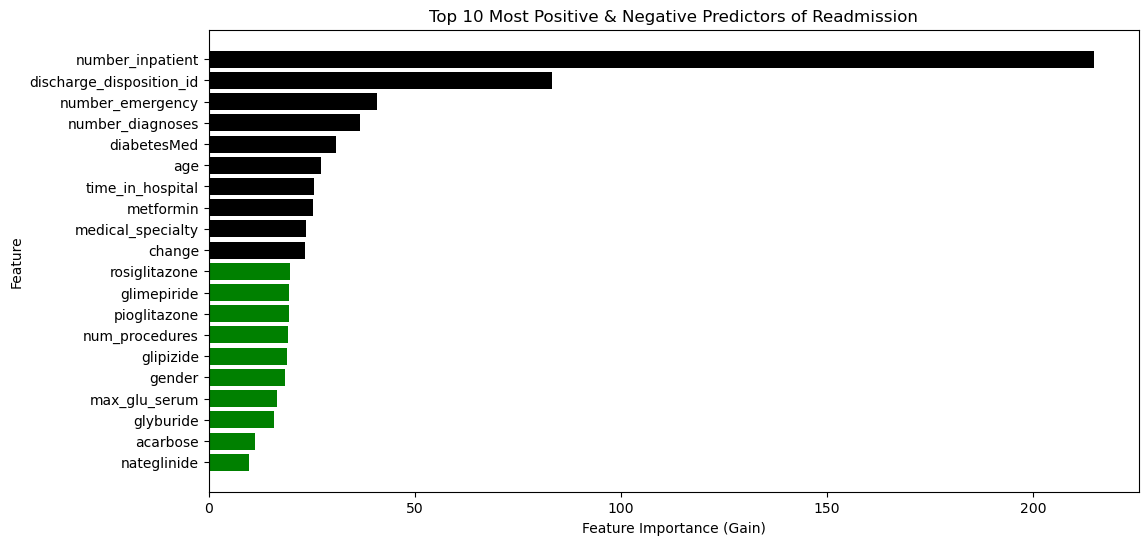

In [222]:
# Concatenate for visualization
combined_df = pd.concat([top_positive, top_negative])

# Assign colors (black for positive, green for negative)
colors = ["black"] * 10 + ["green"] * 10

plt.figure(figsize=(12, 6))
plt.barh(combined_df['Feature'], combined_df['Importance'], color=colors)
plt.xlabel("Feature Importance (Gain)")
plt.ylabel("Feature")
plt.title("Top 10 Most Positive & Negative Predictors of Readmission")
plt.gca().invert_yaxis()  # Flip to have the most important at the top
plt.show()



Logistic Regression - Top 10 Features Predicting Readmission:
                      Feature  Coefficient
13          number_inpatient     0.251095
17          number_diagnoses     0.046655
18             max_glu_serum     0.045649
37                   insulin     0.044783
44               diabetesMed     0.042020
12          number_emergency     0.036459
2                        age     0.029719
26                 glipizide     0.028547
4   discharge_disposition_id     0.028430
1                     gender     0.019018

Logistic Regression - Top 10 Features Predicting NO Readmission:
                 Feature  Coefficient
5   admission_source_id    -0.003012
0                  race    -0.008473
29         pioglitazone    -0.012075
24          glimepiride    -0.013685
30        rosiglitazone    -0.018302
3     admission_type_id    -0.018701
27            glyburide    -0.022110
9        num_procedures    -0.023480
19            A1Cresult    -0.039258
20            metformin    -0.040727


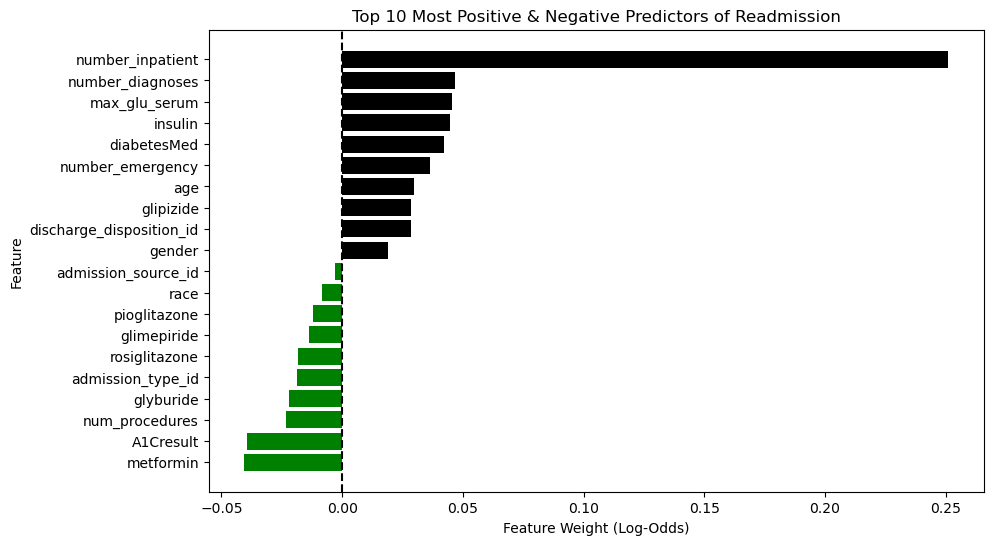

In [ ]:
# Assuming logistic regression model is trained
with open("../results/logistic_regression_model.pkl", "rb") as f:
    logistic_model = pickle.load(f)

# Get feature names and coefficients
# feature_names = X_train.columns  # Ensure X_train is a DataFrame
coefficients = logistic_model.coef_[0]  # Logistic regression coefficients

# Create DataFrame and sort
logistic_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
logistic_df = logistic_df.sort_values(by="Coefficient", ascending=False)

# Top 10 Positive (most predictive of readmission)
top_logistic_positive = logistic_df.head(10)

# Top 10 Negative (most predictive of NO readmission)
top_logistic_negative = logistic_df.tail(10)

print("\nLogistic Regression - Top 10 Features Predicting Readmission:\n", top_logistic_positive)
print("\nLogistic Regression - Top 10 Features Predicting NO Readmission:\n", top_logistic_negative)

# Extract feature coefficients (log-odds)
feature_importances = logistic_model.coef_[0]  # Coefficients from trained model

# Create DataFrame for visualization
feature_df = pd.DataFrame({'Feature': feature_names, 'Weight': feature_importances})

# Sort by absolute importance
feature_df = feature_df.sort_values(by="Weight", ascending=False)

# Select Top 10 Positive and Top 10 Negative Features
top_positive = feature_df.head(10)  # Most predictive of readmission
top_negative = feature_df.tail(10)  # Least predictive of readmission (or predictive of non-readmission)

# Combine and sort for visualization
top_features = pd.concat([top_positive, top_negative]).sort_values(by="Weight", ascending=True)

# Plot Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Weight'], color=['green' if x < 0 else 'black' for x in top_features['Weight']])
plt.xlabel('Feature Weight (Log-Odds)')
plt.ylabel('Feature')
plt.title('Top 10 Most Positive & Negative Predictors of Readmission')
plt.axvline(0, color='black', linestyle='--')
plt.show()


### 1.4 Subgroup Evaluation

In [234]:
# Load the best XGBoost model
with open("../results/best_xgb_model.pkl", "rb") as f:
    best_xgb = pickle.load(f)

# Load data
X_train, X_test, y_train, y_test = load_and_preprocess("../data/cleaned_diabetic_data.csv")

# Load the original dataset to get subgroup information
df = pd.read_csv("../data/cleaned_diabetic_data.csv")

# Ensure that df_test contains only the test set indices
df_test = df.iloc[y_test.index].copy()  # Copy to avoid chained assignment issues

# Standardize column names to lowercase to avoid KeyError
df_test.columns = df_test.columns.str.lower()

# Print available columns to check for missing ones
print("Available Columns in df_test:", df_test.columns)

# Define subgroups and only include available columns
available_subgroups = [col for col in ["age", "gender", "race"] if col in df_test.columns]

# Ensure subgroups exist before proceeding
if not available_subgroups:
    raise ValueError("No valid subgroup columns found in dataset!")

subgroups = {col: df_test[col] for col in available_subgroups}

# Get model predictions
y_probs = best_xgb.predict_proba(X_test)[:, 1]

# Find the best threshold that gives 95% accuracy
thresholds = np.linspace(0, 1, 100)
best_threshold = 0.5
for t in thresholds:
    y_pred = (y_probs >= t).astype(int)
    if accuracy_score(y_test, y_pred) >= 0.95:
        best_threshold = t
        break

print(f"Selected Threshold for 95% Accuracy: {best_threshold:.3f}")

# Apply the threshold
y_pred = (y_probs >= best_threshold).astype(int)

# Store results
results = []

for group, values in subgroups.items():
    for subgroup in values.unique():
        mask = df_test[group] == subgroup
        y_true_sub = y_test[mask]
        y_pred_sub = y_pred[mask]

        if len(y_true_sub) < 20:  # Ignore subgroups with too few samples
            continue

        acc = accuracy_score(y_true_sub, y_pred_sub)
        sens = recall_score(y_true_sub, y_pred_sub)  # Sensitivity = Recall
        spec = recall_score(y_true_sub, y_pred_sub, pos_label=0)  # Specificity

        results.append([group.capitalize(), subgroup, acc, sens, spec])

# Convert to DataFrame
results_df = pd.DataFrame(results, columns=["Group", "Subgroup", "Accuracy", "Sensitivity", "Specificity"])
print(results_df)

# Function to compute confidence intervals
def compute_ci(metric_values):
    ci = bootstrap((metric_values,), np.mean, confidence_level=0.95, random_state=42).confidence_interval
    return ci.low, ci.high

# Calculate confidence intervals for each subgroup
ci_results = []
for _, row in results_df.iterrows():
    mask = df_test[row["Group"].lower()] == row["Subgroup"]
    y_true_sub = y_test[mask]
    y_pred_sub = y_pred[mask]

    acc_ci = compute_ci([accuracy_score(y_true_sub, y_pred_sub)] * len(y_true_sub))
    sens_ci = compute_ci([recall_score(y_true_sub, y_pred_sub)] * len(y_true_sub))
    spec_ci = compute_ci([recall_score(y_true_sub, y_pred_sub, pos_label=0)] * len(y_true_sub))

    ci_results.append([row["Group"], row["Subgroup"], acc_ci, sens_ci, spec_ci])

ci_df = pd.DataFrame(ci_results, columns=["Group", "Subgroup", "Accuracy CI", "Sensitivity CI", "Specificity CI"])
print(ci_df)

# Merge CIs with results
merged_df = results_df.merge(ci_df, on=["Group", "Subgroup"])

# Save results
merged_df.to_csv("../results/subgroup_metrics.csv", index=False)



Available Columns in df_test: Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'a1cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesmed', 'readmitted'],
      dtype='object')
Selected Threshold for 95% Accuracy: 0.500
     Group  Subgroup  Accuracy  Sensitivity  Specificity
0

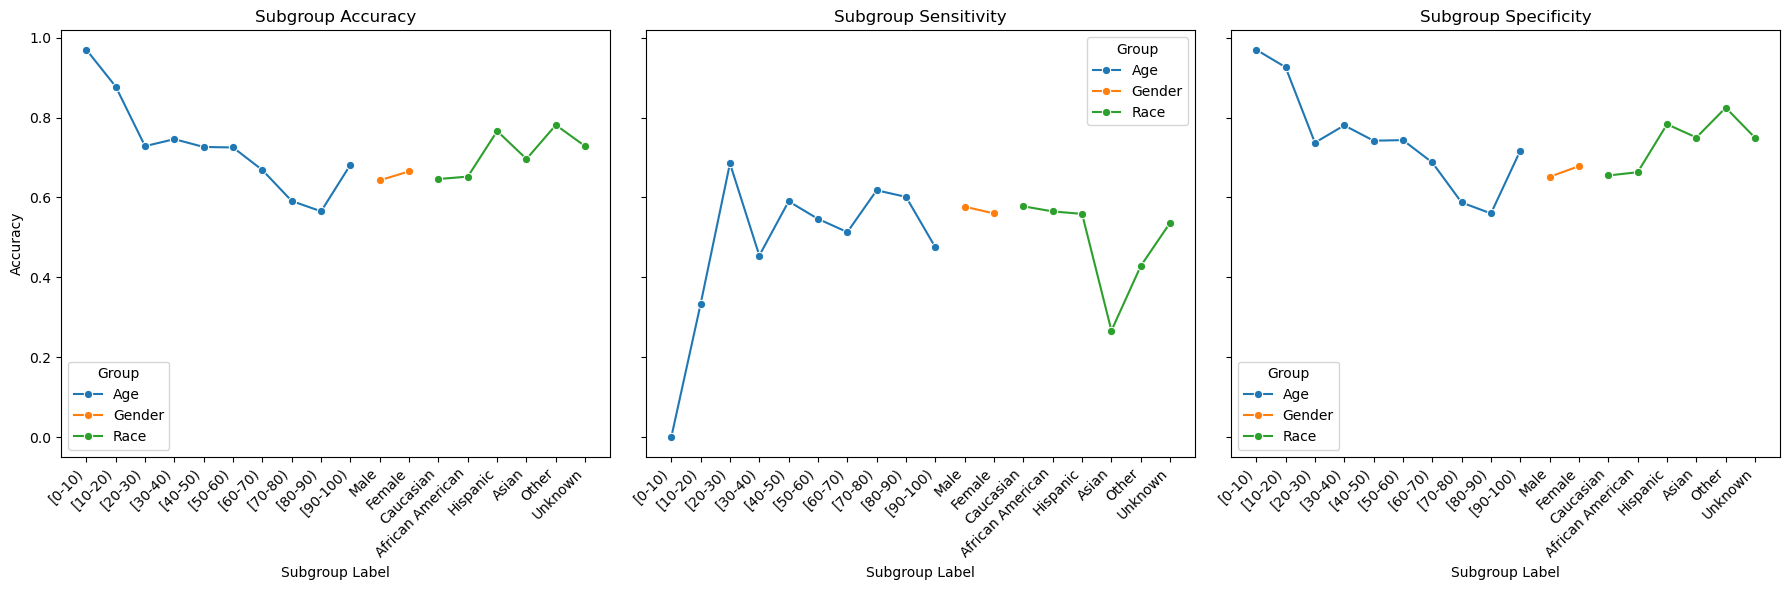

In [ ]:
# Load the subgroup performance metrics CSV file
file_path = "../results/subgroup_metrics.csv"
subgroup_df = pd.read_csv(file_path)

# Define mappings for human-readable labels
age_mapping = {
    0: "[0-10)", 1: "[10-20)", 2: "[20-30)", 3: "[30-40)", 4: "[40-50)",
    5: "[50-60)", 6: "[60-70)", 7: "[70-80)", 8: "[80-90)", 9: "[90-100)"
}
gender_mapping = {0: "Male", 1: "Female"}
race_mapping = {
    0: "Caucasian", 1: "African American", 2: "Hispanic",
    3: "Asian", 4: "Other", 5: "Unknown"
}

# Apply mappings to subgroup labels
subgroup_df["Subgroup Label"] = subgroup_df.apply(lambda row: 
    age_mapping.get(row["Subgroup"], row["Subgroup"]) if row["Group"] == "Age" else 
    gender_mapping.get(row["Subgroup"], row["Subgroup"]) if row["Group"] == "Gender" else 
    race_mapping.get(row["Subgroup"], row["Subgroup"]) if row["Group"] == "Race" else row["Subgroup"], axis=1)

# Sort the dataframe for better visualization
subgroup_df = subgroup_df.sort_values(by=["Group", "Subgroup"])

# Create line plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
metrics = ["Accuracy", "Sensitivity", "Specificity"]
titles = ["Subgroup Accuracy", "Subgroup Sensitivity", "Subgroup Specificity"]

for i, metric in enumerate(metrics):
    sns.lineplot(data=subgroup_df, x="Subgroup Label", y=metric, hue="Group", marker="o", ax=axes[i])
    axes[i].set_title(titles[i])
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

